Notebook to show how a model (SVC) can be traine dto classify keywords into one of 21 
parent DW categories

In [88]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import math
import os, sys, pickle, urllib.request
import os.path as op
from collections import Counter
from tqdm.notebook import tqdm
import gensim
from dateutil.relativedelta import relativedelta
import datetime as d

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from nltk.corpus import stopwords

In [89]:
def evaluate_metrics(yt, yp):
    results_pos = {}
    results_pos['accuracy'] = accuracy_score(yt, yp)
    precision, recall, f_beta, _ = precision_recall_fscore_support(yt, yp, average='weighted')
    results_pos['recall'] = recall
    results_pos['precision'] = precision
    results_pos['f1score'] = f_beta
    return results_pos

In [90]:
# Opening JSON file
data_dir = '/home/marios/data/dw-project-data/CMS_2010_to_June_2022_ENGLISH.json'
f = open(data_dir)
# returns JSON object as
# a dictionary
df = json.load(f)
df = pd.DataFrame.from_dict(df)

In [91]:
#remove columns that are nnot needed
df = df[['id', 'keywordStrings', 'thematicFocusCategory', 'lastModifiedDate']]
#drop missing values
df = df.dropna()
#clean Focus category
df['thematicFocusCategory'] = df['thematicFocusCategory'].apply(lambda x:x['name'] if x is not None else x)
df = df[df['thematicFocusCategory']!=None]
df['thematicFocusCategory'] = df['thematicFocusCategory'].astype(str)

#replacee secondary categories with primary
children_dict = {'Architecture':'Culture', 'Design':'Culture', 'Film':'Culture', 'Arts':'Culture', 
                 'Literature':'Culture', 'Music':'Culture', 'Dance':'Culture', 'Theater':'Culture',
                   'Climate':'Nature and Environment',
                  'Conflicts':'Politics', 'Terrorism':'Politics', 
                  'Corruption':'Law and Justice', 'Crime':'Law and Justice', 'Rule of Law':'Law and Justice',
                    'Press Freedom':'Law and Justice', 
                  'Diversity':'Human Rights', 'Freedom of Speech':'Human Rights', 'Equality':'Human Rights', 
                'Soccer': 'Sports',
                    'Trade':'Business', 'Globalization':'Business', 'Food Security':'Business'
}

secondary_cts = [val for val in children_dict.keys()]

df['thematicFocusCategory'] = df['thematicFocusCategory'].apply(lambda x: children_dict[x] if x in secondary_cts else x)


In [92]:
# let's load a pre-trained word2vec model from google- you may need to download this first
# https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?resourcekey=0-wjGZdNAUop6WykTtMip30g
GoogleModel = gensim.models.KeyedVectors.load_word2vec_format('/home/marios/local_data_s2ds/GoogleNews-vectors-negative300.bin',
                                                               binary=True,)

In [11]:
#drop categories which are rare 
elements_count = collections.Counter(df.thematicFocusCategory)
# printing the element and the frequency
for key, value in elements_count.items():
    if value <100:
        print(f"{key}: {value}")
        df = df[df.thematicFocusCategory != key]


Learning German: 75
Offbeat: 38
Innovation: 5


In [13]:
# creeate corpus which will be passed on for vectorization
# heree one token will bee a string containing all the keywors associateed with one article. 
# you can change this accordingly. 
corpus = [l for l in df['keywordStrings'].apply(lambda x: ', '.join(x))]
corpus[:5]

['Africalink, Top Story, Africa on the Move, Making a Difference, Behind the Headlines, Your Say, Crossroads Generation',
 'Commerzbank, job cuts, administration, retail banking',
 "Moody's, Turkey, ratings agency, junk status",
 'Syria, Aleppo, war crimes, water, UNICEF',
 'Conflict Zone, Talk, link']

In [15]:
# Count vectorization of text
# Creating the vectorizer
vectorizer = CountVectorizer(stop_words='english')
# Converting the text to numeric data
X = vectorizer.fit_transform(corpus) 
# Preparing Data frame For machine learning
# Priority column acts as a target variable and other columns as predictors
CountVectorizedData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
CountVectorizedData['Category']=df['thematicFocusCategory'].values
print(CountVectorizedData.shape)
CountVectorizedData.head()

(79795, 38605)


/home/marios/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,000,007,01,03,04,05,08,0rg,10,100,...,øystein,út,überall,ünal,ünker,ľudmila,şehriban,štefániková,żurek,Category
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,History
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Business
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Business
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Politics
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Politics


In [18]:
WordsVocab=CountVectorizedData.columns[:-1]
print(f'Number of words after count vectorization: {len(WordsVocab)}')

NUmber of words aftere count vectorization: 38604


In [19]:
# this function makes use thee pretrained google model to get word embeddings onn the vectorizeed input 
def FunctionText2Vec(inpTextData):
    # Converting the text to numeric data
    X = vectorizer.transform(inpTextData)
    CountVecData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
    # Creating empty dataframe to hold sentences
    W2Vec_Data=pd.DataFrame()
    # Looping through each row for the data
    for i in range(CountVecData.shape[0]):
        # initiating a sentence with all zeros
        Sentence = np.zeros(300)
        # Looping thru each word in the sentence and if its present in 
        # the Word2Vec model then storing its vector
        for word in WordsVocab[CountVecData.iloc[i , :]>=1]:
            #print(word)
            if word in GoogleModel.key_to_index.keys():    
                Sentence=Sentence+GoogleModel[word]
        # Appending the sentence to the dataframe
        W2Vec_Data=W2Vec_Data.append(pd.DataFrame([Sentence]))
    return(W2Vec_Data)

In [13]:

#this takes aboout an hour to run on my local machine, onnly rerun if you want to overwrite
W2Vec_Data=FunctionText2Vec(corpus)
output_dir = '/home/marios/local_data_s2ds/'
file_name = 'w2v_data_ALL_dirty.npy'
np.save(op.join(output_dir, file_name), W2Vec_Data)

/home/marios/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [35]:
#load saved embeddings if you have them 
word_embedding_dir = '/home/marios/local_data_s2ds/w2v_data_ALL_dirty.npy'
W2Vec_Data = pd.DataFrame(np.load(word_embedding_dir))

In [36]:

# Adding the target variable
W2Vec_Data.reset_index(inplace=True, drop=True)
W2Vec_Data['Category']=CountVectorizedData['Category']
 
# Assigning to DataForML variable
DataForML=W2Vec_Data.copy()
DataForML.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Category
0,0.299662,0.283447,-0.123535,0.349365,-0.561035,-0.381592,0.598633,-1.204590,1.055176,1.244751,...,0.004211,-0.700806,-0.354126,-0.878662,-0.905640,-0.141602,-0.482178,0.404663,0.433105,History
1,0.200317,0.228638,-0.694740,0.358398,-0.019562,-0.473206,-0.455322,-0.468185,0.352570,0.208008,...,-0.106201,-0.200439,-0.055298,0.016968,0.594482,0.263367,-0.120850,0.468994,-0.409668,Business
2,0.110260,-0.127075,-0.201050,0.694519,-0.411407,0.086578,0.196777,-0.756042,0.694824,0.215088,...,1.164688,-0.711182,0.079590,-0.189392,0.060669,0.704670,0.462891,-0.134277,0.358215,Business
3,0.166748,0.611023,0.495667,0.155273,-0.469604,0.094238,0.381165,-0.810547,0.070190,0.612061,...,-0.231689,-0.383667,0.481567,-0.483643,0.057495,-0.515137,-0.443268,0.560913,0.461304,Politics
4,0.175186,-0.080078,0.268250,0.485107,-0.498779,0.637207,0.168701,-0.880371,0.427612,0.146729,...,-0.191406,-0.310791,-0.050293,0.201172,-0.698975,-0.377197,-1.096680,0.198547,-0.334229,Politics


In [37]:
# let's code the y columnns
# let's changee names to numbers 
primary_categories = np.unique(DataForML.Category).tolist()

primary_categories = sorted(primary_categories)
prim_cat_dict = {}
for i, cat in enumerate(primary_categories):
    prim_cat_dict[cat] = i+1

DataForML.Category = DataForML.Category.apply(lambda x: prim_cat_dict[x] if x in prim_cat_dict else x)
DataForML.Category  = DataForML.Category.astype(int)
np.unique(DataForML.Category)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])

In [38]:

# Separate Target Variable and Predictor Variables
TargetVariable=DataForML.columns[-1]
Predictors=DataForML.columns[:-1]
X=DataForML[Predictors].values
y=DataForML[TargetVariable].values

PredictorScaler=MinMaxScaler()
# Storing the fit object for later reference
PredictorScalerFit=PredictorScaler.fit(X)
# Generating the standardized values of X
X=PredictorScalerFit.transform(X)
 
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)

In [41]:
#let's balance classes- if you like 
smote_sampler = SMOTE(random_state = 5)
X_smo_train, y_smo_train = smote_sampler.fit_resample(X_train, y_train)
X_smo_test, y_smo_test = smote_sampler.fit_resample(X_test, y_test)
elements_count = collections.Counter(y_smo_train)
for key, value in elements_count.items():
    print(f"{key}: {value}")

4: 20314
19: 20314
15: 20314
10: 20314
14: 20314
1: 20314
18: 20314
16: 20314
21: 20314
3: 20314
11: 20314
2: 20314
12: 20314
7: 20314
17: 20314
9: 20314
6: 20314
8: 20314
20: 20314
5: 20314
13: 20314


In [43]:
#let's try random forest on this data - not the best model

model = RandomForestClassifier(max_depth= 10, max_features = 'auto', n_estimators= 20)
model.fit(X_smo_train, y_smo_train)
preds = model.predict(X_smo_test)
evaluate_metrics(y_smo_test, preds)

{'accuracy': 0.5990548528026042,
 'recall': 0.5990548528026042,
 'precision': 0.5937706185645542,
 'f1score': 0.5848436441831409}

In [44]:
# try a SVC- performs better- need to try with balanced classes (maybe balance both train and teest data?)
model = SVC(C=20, kernel='rbf')
model.fit(X_smo_train, y_smo_train)
preds = model.predict(X_smo_test)
evaluate_metrics(y_smo_test, preds)

{'accuracy': 0.59175923017618,
 'recall': 0.59175923017618,
 'precision': 0.6569672532546178,
 'f1score': 0.5808744147478248}

In [45]:
#plot confusion matrix... and save model!
# try a SVC- performs better- let's not balance classes
model = SVC(C=20, kernel='rbf')
model.fit(X_train, y_train)
preds = model.predict(X_test)
evaluate_metrics(y_test, preds)

{'accuracy': 0.7217179964303345,
 'recall': 0.7217179964303345,
 'precision': 0.7023795614274884,
 'f1score': 0.7075792297563976}

In [ ]:
# if you'd like to optimize hyperparameters- run this over the weekend maybe
params_grid = {
    'C': [25, 50, 150],
    'kernel': ['poly', 'rbf', 'sigmoid']
}
model = SVC()
# Define a GridSearchCV to search the best parameters
grid_search_balanced = GridSearchCV(estimator = model, 
                           param_grid = params_grid, 
                           scoring='f1',
                           cv = 3, verbose = 1)
# Search the best parameters with training data
model_fit_balanced = grid_search_balanced.fit(X_train, y_train)
best_params_balanced = grid_search_balanced.best_params_

In [ ]:
#finally let's try to test oon google keywords- see below 


In [94]:
google_dir = '/home/marios/S2DS/Spring23_DW/data/interim/2022-daily-trending-searches.json'

In [95]:
df_google = pd.read_json(google_dir, orient ='split', compression = 'infer')

In [97]:
df_google = df_google[['value', 'topic_title', 'topic_type', 'date']]
df_google

,value,topic_title,topic_type,date
0,3550,Journey,Band,2022-01-01
1,1350,Miley Cyrus,American singer-songwriter,2022-01-01
2,1000,Countdown,Topic,2022-01-01
3,1000,Rose Parade,Topic,2022-01-01
4,950,2021 Times Square Ball Drop,Event,2022-01-01
...,...,...,...,...
4217,100,American football,Sports,2022-12-31
4218,80,2022,Topic,2022-12-31
4219,70,Bowl game,Topic,2022-12-31
4220,60,Cooking,Topic,2022-12-31


In [104]:
corpus2 = df_google['topic_title'].tolist()
corpus2[:5]


['Journey',
 'Miley Cyrus',
 'Countdown',
 'Rose Parade',
 '2021 Times Square Ball Drop']

In [105]:
# Count vectorization of text
# Creating the vectorizer
vectorizer = CountVectorizer(stop_words='english')
# Converting the text to numeric data
X = vectorizer.fit_transform(corpus2) 
# Preparing Data frame For machine learning
# Priority column acts as a target variable and other columns as predictors
CountVectorizedData=pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

print(CountVectorizedData.shape)
CountVectorizedData.head()

(4222, 1319)


/home/marios/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,11,13th,14,1883,19,2014,2018,2020,2021,2022,...,xvi,yankees,year,yeezy,yellowstone,yom,york,young,zodiac,álvarez
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
WordsVocab=CountVectorizedData.columns
print(f'Number of words after count vectorization: {len(WordsVocab)}')



Number of words after count vectorization: 1319


In [115]:
#this takes aboout an hour to run on my local machine, onnly rerun if you want to overwrite
W2Vec_Data2=FunctionText2Vec(corpus2)

output_dir = '/home/marios/local_data_s2ds/'
file_name = 'w2v_data_google_trends_2022.npy'
np.save(op.join(output_dir, file_name), W2Vec_Data2)

/home/marios/.local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [116]:
Predictors=W2Vec_Data2.columns
X_google_test=W2Vec_Data2[Predictors].values
PredictorScaler=MinMaxScaler()
PredictorScalerFit=PredictorScaler.fit(X_google_test)
# Generating the standardized values of X
X_google_test=PredictorScalerFit.transform(X_google_test)

In [117]:
#now let's predict using best performing model 
preds = model.predict(X_google_test)
df_google['predicted_category'] = preds

In [130]:
prim_num_dict = {}
for (num, cat) in zip(prim_cat_dict.values(), prim_cat_dict.keys()):
    prim_num_dict[num] = cat
prim_num_dict
df_google['predicted_category'] = df_google['predicted_category'].apply(lambda x: prim_num_dict[x] if x in prim_num_dict else x)
df_google['predicted_category']  = df_google['predicted_category'].astype(str)


,value,topic_title,topic_type,date,predicted_category
0,3550,Journey,Band,2022-01-01,Science
1,1350,Miley Cyrus,American singer-songwriter,2022-01-01,Science
2,1000,Countdown,Topic,2022-01-01,Nature and Environment
3,1000,Rose Parade,Topic,2022-01-01,Science
4,950,2021 Times Square Ball Drop,Event,2022-01-01,Science
...,...,...,...,...,...
4217,100,American football,Sports,2022-12-31,Business
4218,80,2022,Topic,2022-12-31,Business
4219,70,Bowl game,Topic,2022-12-31,Science
4220,60,Cooking,Topic,2022-12-31,Science


In [ ]:
def truncate_data(df, start_date, end_date): 
    df['dt_lastModifiedDate'] = df.lastModifiedDate.apply(lambda x: d.datetime.strptime(x[:10], '%Y-%m-%d') if x is not None else x)
    df = df.sort_values(by = 'dt_lastModifiedDate')
    mask = np.logical_and(df['dt_lastModifiedDate']>=start_date, df['dt_lastModifiedDate']<end_date)
    df_subset = df[mask]
    return df_subset

In [200]:
#now let's find if each keyword was published on by DW
for i in range(df_google.shape[0]):
    #slice original df based on dates
    print(i)
    start_date = df_google.date.iloc[i]
    end_date = df_google.date.iloc[i] + relativedelta(months=1)
    df_slice = truncate_data(df, start_date, end_date)
    kws_of_slice = [w for sublist in df_slice.keywordStrings for w in sublist]
    if str(df_google.topic_title[i]) in kws_of_slice:
        print(str(df_google.topic_title[i]))
        df_google.dw_published[i] = 1.0



0
1
2
3
4
5
6
7
New Year's Day
8


/home/marios/.local/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
Tampa Bay Buccaneers
27
28
29
30
31
32
33
34
35
36
NFL
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
License
59
60
61
62
63
64
65
66
67
68
69
70
71
72
Pittsburgh
73
74
75
76
77
78
79
80
81
82
83
84
85
86
NFL
87
88
89
90
Football
91
92
93
94
95
96
Film
97
98
99
100
101
102
103
Tampa Bay Buccaneers
104
105
New England Patriots
106
107
108
109
110
111
112
113
NFL
114
115
116
117
118
119
120
121
Bob Saget
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
License
144
145
146
147
148
149
150
151
152
153
Alabama
154
155
156
157
158
159
160
161
Tonga
162
163
Cincinnati Bengals
164
165
166
NFL
167
New England Patriots
168
169
170
171
172
173
Football
174
175
176
177
178
179
180
181
182
183
184
Tampa Bay Buccaneers
185
186
187
188
189
190
New England Patriots
191
192
193
194
195
196
Super Bowl
197
198
NFL
199
200
201
202
203
204
205
206
207
208
209
210
211
Pittsburgh
212
213
214
215
216

Business
0.05726872246696035
Culture
0.20512820512820512
Health
0.06557377049180328
Nature and Environment
0.06236559139784946
Politics
0.0379746835443038
Science
0.06628895184135977
Society
0.0


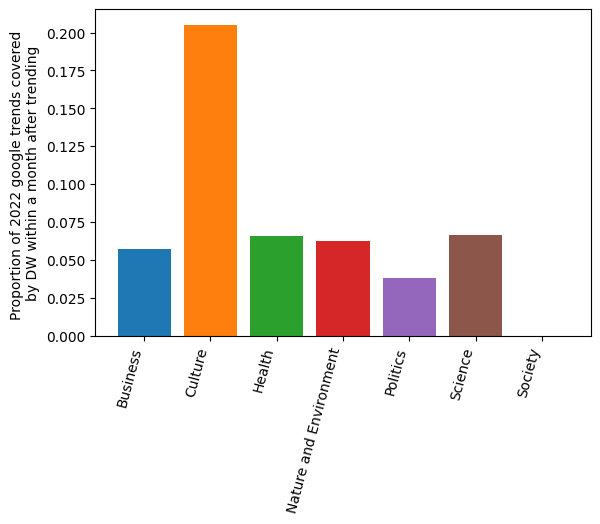

In [216]:
#leet's group by eeach category, get the ratio of 1.0's and 0.0's and plot it 
cats = np.unique(df_google.predicted_category)
fig,ax = plt.subplots()
for cat in cats:
    print(cat)
    df_sub = df_google[df_google.predicted_category == cat]
    ratio = np.sum(df_sub.dw_published)/df_sub.shape[0]
    print(ratio)
    ax.bar(cat, ratio)
fig.autofmt_xdate(rotation=75)

ax.set_ylabel('Proportion of 2022 google trends covered \nby DW within a month after trending')
plt.show()


In [226]:
df_google[df_google.predicted_category=='Culture']

,value,topic_title,topic_type,date,predicted_category,dw_published
13,300,Singer,Profession,2022-01-01,Culture,0.0
96,40,Film,Topic,2022-01-08,Culture,1.0
235,550,Singer,Profession,2022-01-21,Culture,0.0
262,50,Film,Topic,2022-01-22,Culture,1.0
335,60,Film,Topic,2022-01-29,Culture,1.0
487,70,Cinema,Building use,2022-02-12,Culture,0.0
707,50,Cinema,Building use,2022-03-05,Culture,0.0
711,40,Film,Topic,2022-03-05,Culture,1.0
761,50,Film,Topic,2022-03-12,Culture,1.0
908,40,Film,Topic,2022-03-26,Culture,0.0
